In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions.dsb2017 import dsbconfig as comp;
import dicom
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from nbpapaya import Brain, clear_brain, Brain, Surface, Overlay
import SimpleITK as sitk
import csv
import xml
from bs4 import BeautifulSoup

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
PROJECT_PATH = os.path.join('/bigguy/data/luna')
DATA_PATH = os.path.join('/bigguy/data/luna/data')
META_PATH = os.path.join(PROJECT_PATH, 'csv')
EXTRACTED_IMG_PATH = os.path.join(PROJECT_PATH, 'extracted_imgs')
EXTRACTED_LABEL_PATH = os.path.join(PROJECT_PATH, 'extracted_labels')
ANNOTATIONS_PATH = os.path.join(META_PATH, 'annotations.csv')
LIDC_ANNO_PATH = os.path.join(META_PATH, 'lidc_annotations')
MEAN_PIXEL_VALUE_NODULE = 41
SEGMENTER_IMG_SIZE = 320
TARGET_VOXEL_MM = 1.00
VOXEL_SPACING = [TARGET_VOXEL_MM, TARGET_VOXEL_MM, TARGET_VOXEL_MM]
subset_path = os.path.join(DATA_PATH, 'subset0')
fpaths = glob(subset_path+"/*.mhd")

In [402]:
def get_mhd_path_from_patient_id(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def load_arr_from_mhd(filename):
    itkimage = sitk.ReadImage(filename)
    img_arr = sitk.GetArrayFromImage(itkimage)
    # SimpleITK output is [x,y,z] but numpy is [z,y,x], so we reverse
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return img_arr, origin, spacing

def load_scan_arr(patient_id):
    img_fpath = get_mhd_path_from_patient_id(patient_id)
    img_arr, origin, spacing = load_arr_from_mhd(img_fpath)
    img_arr = normalize(img_arr)
    return img_arr, origin, spacing

def get_scan_bbs(patient_id, anno_df):
    img_arr, origin, spacing = load_scan_arr(patient_id)
    nodules = anno_df[anno_df.patient_id == patient_id]
    bbs = []
    for idx,nodule in nodules.iterrows():
        bbs.append(make_bb_from_nodule(nodule, origin, spacing))
    return bbs
    
def make_bb_from_nodule(nodule, origin, spacing):
    coords_mm = np.array([nodule['coord_z'], nodule['coord_y'], nodule['coord_x']])
    coords_mm = coords_mm - origin
    diameter = nodule['diameter']
    bb = make_bb_from_mm_coords(
        coords_mm[0], coords_mm[1], coords_mm[2], diameter, spacing)
    return bb

def make_bb_from_mm_coords(z_center, y_center, x_center, diameter, spacing):
    radius_mm = diameter / 2
    z_spacing = spacing[0]
    y_spacing = spacing[1]
    x_spacing = spacing[2]
    y_min_mm = y_center - radius_mm
    x_min_mm = x_center - radius_mm
    y_max_mm = y_center + radius_mm
    x_max_mm = x_center + radius_mm

    z_center_pixels = int(round(z_center / z_spacing))
    y_center_pixels = int(round(y_center / y_spacing))
    x_center_pixels = int(round(x_center / x_spacing))
    y_min_pixels = int(round(y_min_mm / y_spacing))
    x_min_pixels = int(round(x_min_mm / x_spacing))
    y_max_pixels = int(round(y_max_mm / y_spacing))
    x_max_pixels = int(round(x_max_mm / x_spacing))
    bb = make_bb_from_pixel_coords(z_center_pixels, y_min_pixels, y_max_pixels, 
                                   x_min_pixels, x_max_pixels)
    return bb
    
def make_bb_from_pixel_coords(z, ymin, ymax, xmin, xmax, label="nodule"):
    return {
        'label': label,
        'slice': int(round(z)),
        'xmin': int(round(xmin)),
        'ymin': int(round(ymin)),
        'xmax': int(round(xmax)),
        'ymax': int(round(ymax))
    }

def get_slice_idx_to_bb_map(bbs):
    idxs = {}
    for bb in bbs:
        if bb['slice'] in idxs:
            idxs[bb['slice']].append(bb)
        else:
            idxs[bb['slice']] = [bb]
    return idxs

def plot_slice_w_bbs(slice_arr, bbs, title=None):
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = plt.gca()
    for bb in bbs:
        nodule_xy = bb['xmin'], bb['ymin']
        width = bb['xmax'] - bb['xmin']
        height = bb['ymax'] - bb['ymin']
        box = plt.Rectangle(nodule_xy, width, height, fill=False, 
                            edgecolor='white', linewidth=1)
        ax.add_patch(box)
    plt.imshow(slice_arr, cmap=plt.cm.Greys_r, 
               vmin=slice_arr.min(), vmax=slice_arr.max());
    plt.title(title)
    
def plot_slices_w_nodules(patient_id, anno_df):
    print("Patient: ", patient_id)
    img_arr, origin, spacing = load_scan_arr(patient_id)
    bbs = get_scan_bbs(patient_id, anno_df)
    slice_idxs = get_slice_idx_to_bb_map(bbs)
    for idx in slice_idxs.keys():
        plot_slice_w_bbs(img_arr[idx], slice_idxs[idx], title="slice:"+str(idx))

In [403]:
luna_anno_df = pd.read_csv(os.path.join(META_PATH, "annotations.csv"))
luna_anno_df.columns = ['patient_id', 'coord_x', 'coord_y', 'coord_z', 'diameter']
# lidc_anno_df = lidc_pos_df = pd.read_csv(os.path.join(META_PATH, "lidc_annotations.csv"))
# anno_df = luna_anno_df

In [408]:
patient_idx = random.randint(0,len(anno_df)-1)
patient_id = anno_df.iloc[patient_idx].patient_id
img_arr, origin, spacing = load_scan_arr(patient_id)
bbs = get_scan_bbs(patient_id, anno_df)
slice_idxs = get_slice_idx_to_bb_map(bbs)
slice_idx = list(slice_idxs.keys())[0]
print(slice_idx, slice_idxs)

88 {88: [{'label': 'nodule', 'slice': 88, 'xmin': 271, 'ymin': 346, 'xmax': 278, 'ymax': 353}], 97: [{'label': 'nodule', 'slice': 97, 'xmin': 356, 'ymin': 208, 'xmax': 364, 'ymax': 216}]}


Patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.454273545863197752384437758130


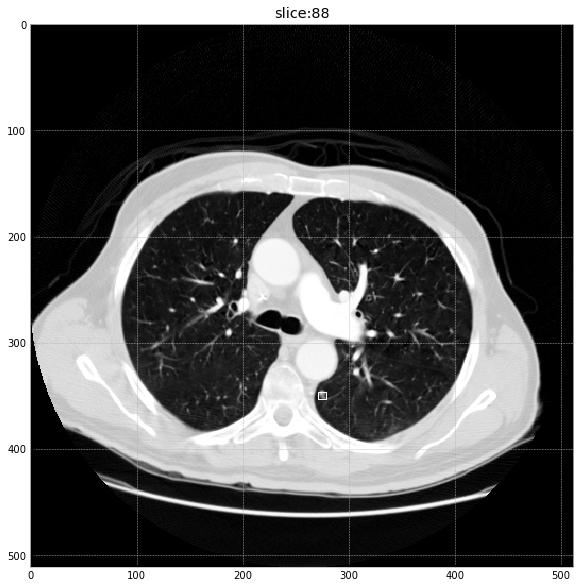

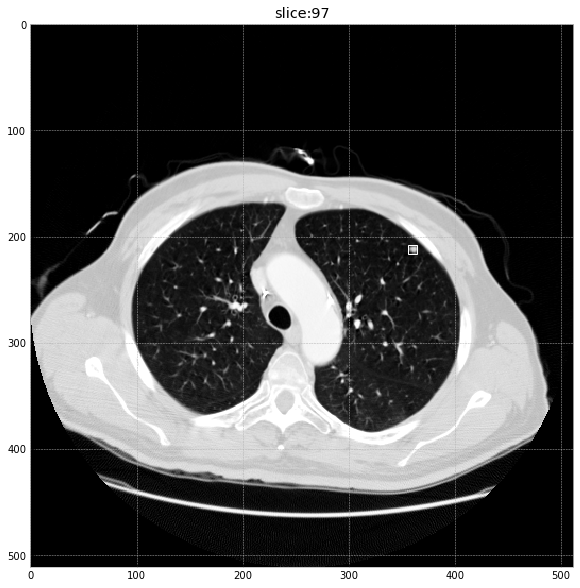

In [409]:
#plot_slice_w_bbs(img_arr[slice_idx,:,:], slice_idxs[slice_idx])
plot_slices_w_nodules(patient_id, anno_df)